Found CRS for 20161225T051222_20161225T051551_T43PGN.tif: EPSG:32643
20161225T051222_20161225T051551_T43PGN.tif: 218940200.0 sq meters
20170223T050811_20170223T051515_T43PGN.tif: 203998500.0 sq meters
20180203T051019_20180203T052538_T43PGN.tif: 190801500.0 sq meters
20180218T050851_20180218T052043_T43PGN.tif: 204020400.0 sq meters
20180223T050809_20180223T051831_T43PGN.tif: 196084700.0 sq meters
20190208T050959_20190208T052314_T43PGN.tif: 194706800.0 sq meters
20190213T050921_20190213T052353_T43PGN.tif: 197009700.0 sq meters
20190223T050811_20190223T051829_T43PGN.tif: 191897000.0 sq meters
20200203T051019_20200203T052524_T43PGN.tif: 196570800.0 sq meters
20200218T050851_20200218T051826_T43PGN.tif: 198536800.0 sq meters
20210202T051031_20210202T052158_T43PGN.tif: 213693600.0 sq meters
20210207T050959_20210207T051907_T43PGN.tif: 205734300.0 sq meters
20210212T050931_20210212T051356_T43PGN.tif: 211461300.0 sq meters
20220123T051109_20220123T051704_T43PGN.tif: 208112300.0 sq meters
2022030

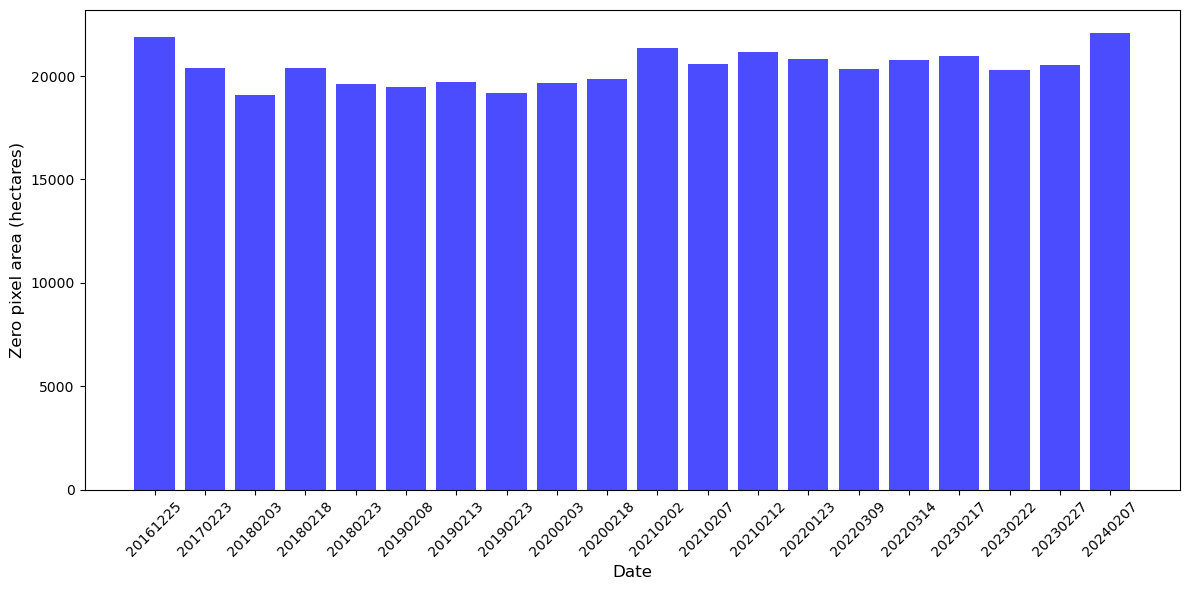

In [2]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
import os
import csv
import matplotlib.pyplot as plt
from pyproj import CRS
import math

# Initialize two lists globally to store filenames and their corresponding pixel area values
filenames_list = []
pixel_areas_list = []

def get_utm_crs(longitude, latitude):
    """Generate the UTM CRS based on longitude and latitude."""
    zone = math.floor((longitude + 180) / 6) + 1  # UTM zones are 6 degrees wide
    is_northern = latitude >= 0
    epsg_code = 32600 + zone if is_northern else 32700 + zone

    # Validate the EPSG code
    try:
        crs = CRS.from_epsg(epsg_code)
        return crs
    except:
        print(f"Invalid EPSG code: {epsg_code}")
        return None


def get_first_image_utm_crs(folder_path):
    """Find the first .tif image in the folder and calculate its UTM CRS."""
    for filename in os.listdir(folder_path):
        if filename.endswith('.tif'):  # Check for .tif files
            file_path = os.path.join(folder_path, filename)
            with rasterio.open(file_path) as src:
                # Check if the file has a valid CRS
                if src.crs is None:
                    print(f"Warning: {filename} has no CRS. Skipping.")
                    continue
                # Get the CRS from the file if available
                existing_crs = src.crs
                print(f"Found CRS for {filename}: {existing_crs}")
                return existing_crs
    
    print("No valid CRS found in the folder.")
    return None


def reproject_to_utm(src_image_path, dst_folder, target_crs):
    with rasterio.open(src_image_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, target_crs, src.width, src.height, *src.bounds)
        
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': target_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        # Create the output file path
        dst_image_path = os.path.join(dst_folder, f"reprojected_{os.path.basename(src_image_path)}")

        # Write the reprojected file to the destination folder
        with rasterio.open(dst_image_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs,
                    resampling=Resampling.nearest)

        return dst_image_path

# Function to calculate pixel area for value 0 in square meters
def calculate_zero_pixel_area(image_path, zero_value=2, tolerance=0):
    with rasterio.open(image_path) as dataset:
        image = dataset.read(1)  # Read the single-band raster
        
        # Handle NoData values
        nodata_value = dataset.nodata
        if nodata_value is not None:
            image = np.ma.masked_equal(image, nodata_value)

        # Get the pixel size in meters
        pixel_size_x = dataset.transform[0]  # Pixel width in meters
        pixel_size_y = -dataset.transform[4]  # Pixel height in meters
        pixel_area = pixel_size_x * pixel_size_y  # Pixel area in square meters

        # Count the zero pixels within the tolerance range
        if tolerance > 0:
            zero_pixel_count = np.sum(np.abs(image - zero_value) <= tolerance)
        else:
            zero_pixel_count = np.sum(image == zero_value)

        # Calculate total zero pixel area in square meters
        total_zero_area_m2 = zero_pixel_count * pixel_area

        return total_zero_area_m2

# Function to process multiple TIFF files from a folder, reproject, and calculate zero pixel area
def process_folder(folder_path, output_csv, target_crs, zero_value, tolerance=0):
    global filenames_list, pixel_areas_list  # Use the global lists

    # Set the destination folder for reprojected files
    dst_folder = os.path.join(folder_path, "New folder")
    if not os.path.exists(dst_folder):
        os.makedirs(dst_folder)  # Create the destination folder if it doesn't exist

    # Open the CSV file to write the results
    with open(output_csv, mode='w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        # Write the header row
        csv_writer.writerow(['Filename', 'Zero Pixel Area (sq meters)'])

        # Loop through all files in the folder
        for filename in os.listdir(folder_path):
            if filename.endswith('.tif'):  # Process only .tif files
                file_path = os.path.join(folder_path, filename)

                try:
                    # Step 1: Reproject the raster to the target CRS and save the reprojected file in the new folder
                    reprojected_path = reproject_to_utm(file_path, dst_folder, target_crs)

                    # Step 2: Calculate the zero pixel area in square meters
                    zero_area_m2 = calculate_zero_pixel_area(reprojected_path, zero_value, tolerance)

                    # Step 3: Add filename (without '.tif') and area to the respective global lists
                    filenames_list.append(filename.replace('.tif', ''))
                    pixel_areas_list.append(zero_area_m2)

                    # Step 4: Write the result to the CSV
                    csv_writer.writerow([filename, zero_area_m2])

                    # Print the final calculated value for each image
                    print(f"{filename}: {zero_area_m2} sq meters")
                except Exception as e:
                    print(f"Error processing {filename}: {e}")

# Function to plot zero pixel area as a bar chart
def plot_zero_pixel_areas(dates, areas):
    # Convert areas from square meters to hectares
    areas_hectares = [area / 10000 for area in areas]
    dates = [date[:8] for date in dates]
    
    # Plot the bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(dates, areas_hectares, color='blue', alpha=0.7)
    
    # Setting the chart details
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Zero pixel area (hectares)", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    
    # Show the plot
    plt.savefig('C:/Users/apsam/Documents/work/Thiyaku work/urban-growth-coimbatore/plot.jpg', format='jpg', dpi=300)
    plt.show()

# Example usage
folder_path = 'C:/Users/apsam/Documents/work/Thiyaku work/blog_urban_growth/classified_v2'
output_csv = 'zero_pixel_areas_in_square_meters.csv'

target_crs = get_first_image_utm_crs(folder_path)
#print(target_crs)# Replace with the appropriate UTM zone or another metric-based CRS
zero_value = 2  # Target pixel value is 0 for zero pixel area
tolerance = 0  # Set tolerance if the raster data is float and the zero value needs a range

# Process the folder and store the results in CSV
process_folder(folder_path, output_csv, target_crs, zero_value, tolerance=tolerance)

# Plot the zero pixel areas
plot_zero_pixel_areas(filenames_list, pixel_areas_list)
